# Script to create composites of SST gradient based on ENSO phase

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import xarray as xr

from grad_funcs import get_gs_coords_alltime,get_total_gradient
from global_land_mask import globe

In [228]:
## months to perform analysis, for full year set analysis_months = range(1,13)

analysis_months = [1,2,12]
figtitle = 'SST_ERA5_DJF_nroll_2.png'


dslink = '/Users/noahrosenberg/Downloads/era5_sst_1940_2022_1deg.nc'

unit_conv = 100 #unit scaling for the gradient, set to 1/1000 for m**-1 or 100 for (100 km)**-1
nroll = 2


ds = xr.load_dataset(f'{dslink}',engine='netcdf4')
ds = ds.where(ds.time.dt.month.isin(analysis_months))

sst = ds.sst # set to data variable you want to look at

lons = ds.lon #rename based on latitude/longitude variables
lats = ds.lat
latname = 'lat' #also rename these for grad calculation function
lonname = 'lon'

x = lons.to_numpy()
x = np.where(x>180,x-360,x)
x,y = np.meshgrid(x,lats)
sst = sst.where(globe.is_ocean(y,x)) ## mask out land values 

nino_dates = np.load('ninodates.npy',allow_pickle=True) #read in files generated from Nino3.4.ipynb containing ENSO dates
nina_dates = np.load('ninadates.npy',allow_pickle=True)

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [229]:
## get dates from Nino script and dataarray into same format



nino_months = nino_dates.astype('datetime64[M]')

year0 = sst.time.dt.year.min()
year0 = int(year0)

nino_indices = nino_months.astype('int')+(1970-year0)*12

sst_month_indices = (sst.time.dt.year-year0)*12 + sst.time.dt.month

sst_nino = sst.where(sst_month_indices.isin(nino_indices),drop=True)
sst_nino = sst_nino

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


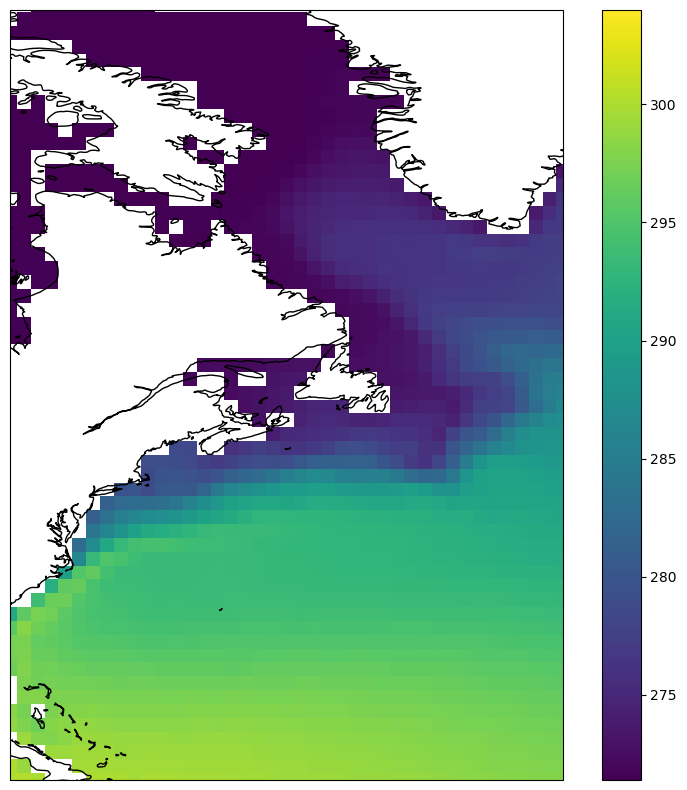

In [230]:
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
im = ax.pcolormesh(lons,lats,sst_nino.mean('time').where(globe.is_ocean(y,x)),transform=ccrs.PlateCarree())
#im2 = ax.contour(sst.lon,sst.lat,tot_grad.mean('time'),levels=(1,288),c='r')

ax.set_extent((-80,-40,20,75))
plt.colorbar(im,ax=ax)
ax.coastlines()

In [231]:


nina_months = nina_dates.astype('datetime64[M]')

year0 = sst.time.dt.year.min()
year0 = int(year0)

nina_indices = nina_months.astype('int')+(1970-year0)*12

sst_month_indices = (sst.time.dt.year-year0)*12 + sst.time.dt.month

sst_nina = sst.where(sst_month_indices.isin(nina_indices),drop=True)

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


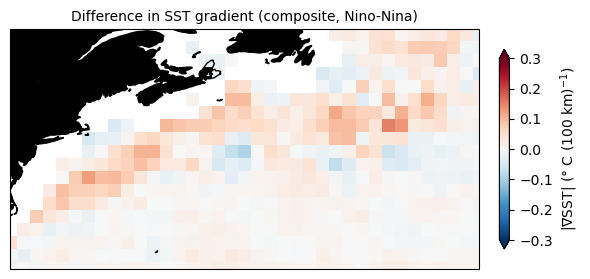

In [232]:
from matplotlib import colors
from cartopy import feature

# plot difference in gradients between 2 composites

nina_grad = get_total_gradient(sst_nina,nroll,latname=latname,lonname=lonname).mean('time')*unit_conv
nino_grad = get_total_gradient(sst,nroll,latname=latname,lonname=lonname).mean('time')*unit_conv

fig,ax = plt.subplots(figsize=(6,5),subplot_kw={'projection':ccrs.PlateCarree()})
im = ax.pcolormesh(lons,lats,
                   nino_grad-nina_grad,
                   transform=ccrs.PlateCarree(),
                   #vmin=0,vmax=0.03,
                   cmap="RdBu_r",norm=colors.CenteredNorm(0,0.3))#(0,0.0005))#,cmap='RdBu_r')
ax.coastlines()
ax.add_feature(feature.LAND,facecolor='k')#,transform=ccrs.PlateCarree())

#im2 = ax.contour(sst.longitude,sst.latitude,sst.mean('time'),levels=20,colors='k',linewidths=0.5)

#im2 = ax.contour(sst.lon,sst.lat,tot_grad.mean('time'),levels=(1,288),c='r')

ax.set_extent((-76,-40,31,48))
plt.colorbar(im,ax=ax,fraction=0.02, pad=0.04,extend='both',
             #label = r'$|\nabla$SHF| (J m$^{-3}$)')#' (100 km)$^{-1}$)')
             label = r'$|\nabla$SST| ($\degree$ C (100 km)$^{-1}$)')
ax.set_title('Difference in SST gradient (composite, Nino-Nina)',fontsize=10)
plt.tight_layout()
plt.savefig(figtitle)

plt.show()

